In [1]:
%run _init_notebook.ipynb
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.distributions import create_serpentine, create_random_gaussian_mixture, IndependentMultivariateNormal, create_gaussian_lattice
from approxmh.samplers import AdaptiveVAESampler
from approxmh.utilities import *
from approxmh.likelihood_estimators import SISLikelihoodEstimator, IWLikelihoodEstimator
from approxmh.y_utils import *

def model_file(model, target_name):
    return Path(MODEL_DIR, get_filename(model, target_name))

def save_model(model, target_name):
    model.save_knowledge(model_file(model, target_name))

def load_model(model, target_name):
    model.load_knowledge(model_file(model, target_name))

device: cpu


2024-08-21 17:17:11.914251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 17:17:11.931888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 17:17:11.937413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 17:17:14.469796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


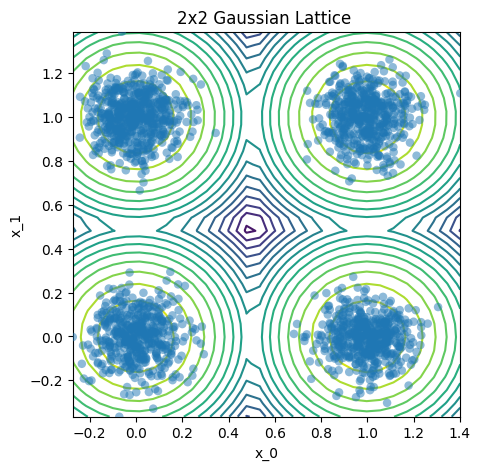

In [8]:
#target = create_random_gaussian_mixture(dim=2, n_components=50, variance_lim=(0.0005, 0.005), seed=43)
target = create_gaussian_lattice(shape=(2, 2), variance=0.01)
visualize_distribution(target, sample_size=2_000, levels=20, plot_samples=True)

In [32]:
vae = VAE(
    data_dim=target.dim,
    hidden_dims=(4, 4, 4, 4, 4, 4),
    latent_dim=target.dim,
    device=device
)

# True -- train model, False -- load model from file
TRAIN_VAE = False

In [33]:
%%time

if TRAIN_VAE:
    vae.decoder.requires_grad_(False)
    x_train = target.sample((16_384,))
    print('VAE parameters:', count_parameters(vae))
    #optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=250)
    trainer = VAETrainer(
        vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
        warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
    )
    trainer.fit(x_train, n_epochs=500, plot_interval=10)
    save_model(vae, target.name)
else:
    load_model(vae, target.name)

CPU times: user 16.7 ms, sys: 0 ns, total: 16.7 ms
Wall time: 18.1 ms


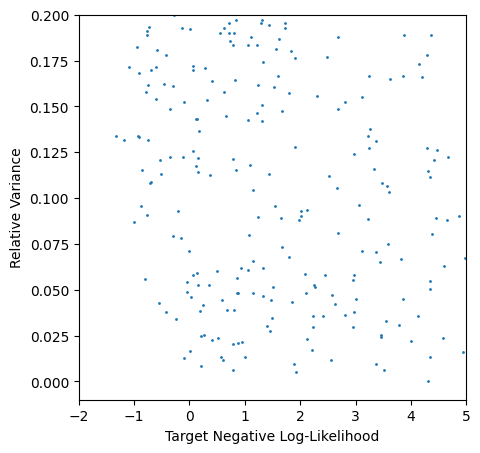

In [34]:
def dependance_of_variance_on_target_likelihood():
    estimator = IWLikelihoodEstimator(
        model=vae,
        L=64
    )
    n_samples = 2000

    vae_samples = vae.sample((n_samples,))
    target_nll = -target.log_prob(vae_samples)
    log_prob_ests, variances = estimator(vae_samples, return_variance=True)
    rel_variances = variances / torch.exp(log_prob_ests)

    clf_xmax = 2
    not_outlier = (rel_variances < 1) & (target_nll < clf_xmax)

    clf = Ridge(alpha=0.)
    clf.fit(target_nll[not_outlier].reshape(-1, 1), rel_variances[not_outlier])
    xs = np.linspace(-1.6, clf_xmax, 100)
    avg_rel_var = clf.predict(xs.reshape(-1, 1))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(to_numpy(target_nll), to_numpy(rel_variances), s=1)
    ax.plot(xs, avg_rel_var, linewidth=4, alpha=0.5, color='red')
    ax.set_ylim(-0.01, 0.2)
    ax.set_xlim(-2, 5)
    ax.set_xlabel('Target Negative Log-Likelihood')
    ax.set_ylabel('Relative Variance')

dependance_of_variance_on_target_likelihood()

In [ ]:
def relative_variance_visualization(n_samples=2000):
    estimator = SISLikelihoodEstimator(
        model=vae,
        L=256,
        n_steps=10,
        time_step=0.009,
    )
    vae_samples = vae.sample((n_samples,))
    
    log_likelihoods, variances = estimator(vae_samples, return_variance=True)
    rel_variances = variances / torch.exp(log_likelihoods * 2)

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    ax = axs[0]
    ax.set_title('Relative Std')
    cmap = plt.get_cmap('viridis')
    cmap.set_over('red')
    sc = ax.scatter(*pl(vae_samples), c=to_numpy(rel_variances), cmap=cmap, vmax=1, s=2)
    plt.colorbar(sc, extend='max')
    ax = axs[1]
    ax.hist(to_numpy(rel_variances), range=(0,2), bins=100)
    print(f'Average relative variance: {rel_variances.mean().item():0.4f}')
    print(f'Median relative variance: {rel_variances.median().item():0.4f}')

relative_variance_visualization()

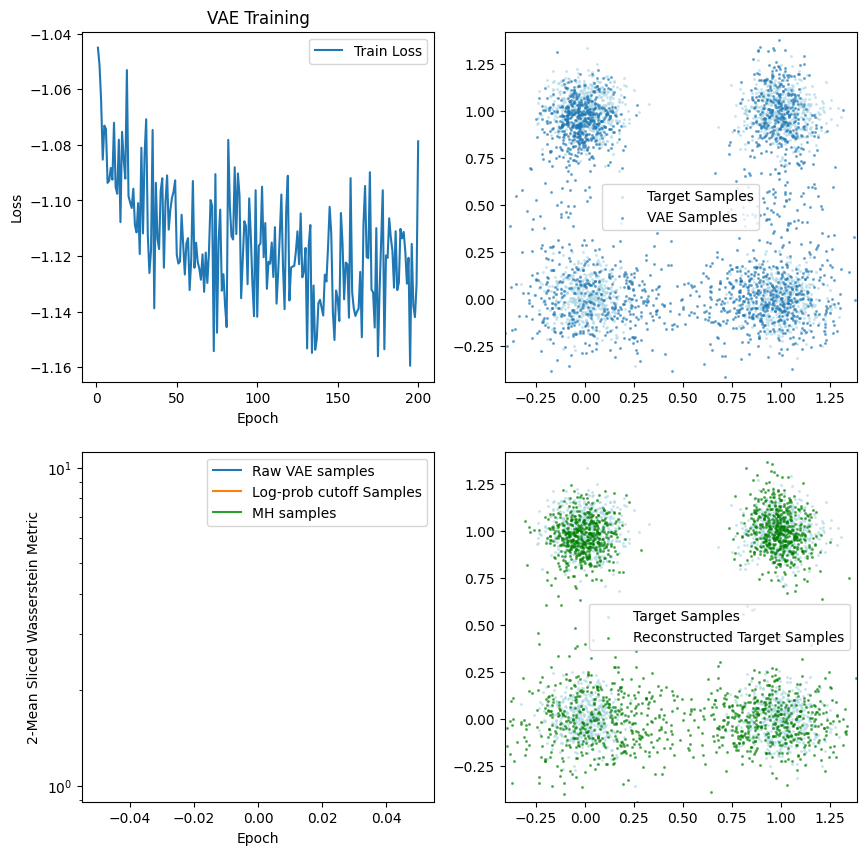

Epoch 200
	Train loss: -1.0787
	Validation loss: -1.5917
	Learning rate: 0.0001


In [37]:
n_decoder_samples = 16_384
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=125)
trainer = VAETrainer(
    vae, target, batch_size=2048, no_kl_penalty_epochs=0, kl_annealing_epochs=1, 
    warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
)
trainer.tune_encoder(n_decoder_samples, n_epochs=200, plot_interval=20, plot_from=0)

Average relative variance: 0.6838
Median relative variance: 0.2261


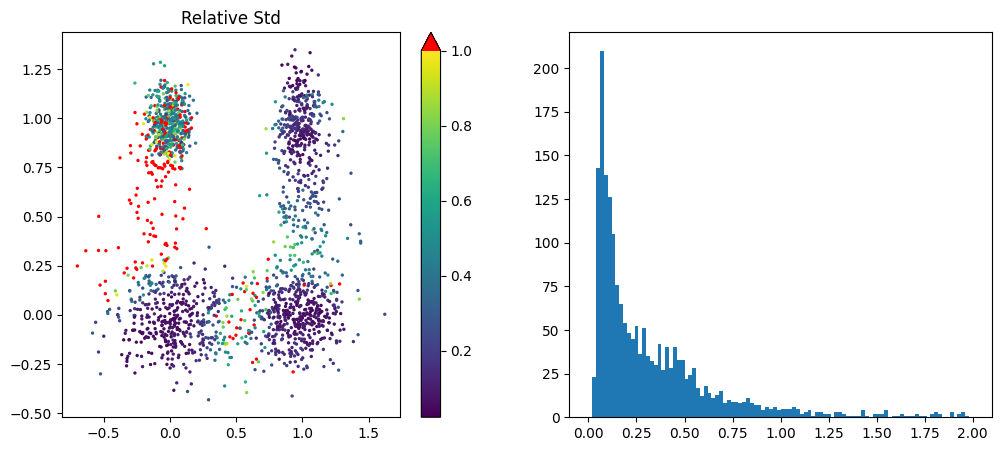

In [40]:
relative_variance_visualization()